### Description

### load 

In [1]:
import os
import random 
import pickle
import sys
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

root_path = os.path.dirname(os.path.dirname(os.path.abspath(os.getcwd())))
# to import src is necessary to append the root_path to the path
#sys.path.append(root_path)

data_path = os.path.join(root_path,'data')
results_path = os.path.join(root_path,'results')

### Define global variables

In [2]:
WITH_STEMMING = True
REMOVE_STOPWORDS = True
MINIMUM_WORDS_PER_PHRASE = 0
GROUP = -1
SEED = 10
num_topics = 60
random.seed(SEED)

In [3]:
df = pd.read_excel('IBL_topic_distribution_by_utterance_cooccurrence_minimum_0_words_with_stemming.xlsx')

In [4]:
df.columns

Index(['Topic 1', 'Topic 2', 'Topic 3', 'Topic 4', 'Topic 5', 'Topic 6',
       'Topic 7', 'Topic 8', 'Topic 9', 'Topic 10',
       ...
       'Topic 60-Topic 59', 'phase', 'phase_1', 'phase_2', 'phase_3',
       'phase_4', 'phase_5', 'utterance', 'length utterance',
       'utterance_relative_time'],
      dtype='object', length=1839)

### split dataset

In [5]:
the_keys = list(set(df['phase']))
for key in the_keys:
    n = list(df.phase.values).count(key)
    print("key {}, total {}".format(key,n))

key 1, total 474
key 2, total 209
key 3, total 477
key 4, total 70
key 5, total 653


In [6]:
trainset = {}
testset = {}
for name, group in df.groupby(['phase']):
    trainset[name]=[]
    testset[name]=[]
    n = len(group)
    ra = random.sample(range(n),int(n*0.2))
    print("test set phase {}: {}".format(name,int(n*0.2)))
    count = 0
    group = group.reset_index()
    for i,row in group.iterrows():
        if i in ra:
            count+=1
            testset[name].append(row.values)
        else:
            trainset[name].append(row.values)


test set phase 1: 94
test set phase 2: 41
test set phase 3: 95
test set phase 4: 14
test set phase 5: 130


In [7]:
filter_rows = list(range(1,1831))+[1838,1839]
#filter_labels = [3601]

In [8]:
def get_data_from_dict(a_dict):
    y = []
    X = []
    for key in a_dict:
        rows = a_dict[key]
        for row in rows:
            X.append(row[filter_rows])
            y.append(key)
    return X,y

In [9]:
X_train,y_train = get_data_from_dict(trainset)
X_test,y_test = get_data_from_dict(testset)

In [10]:
print(y_test.count(4))
print(len(X_train[0]))

14
1832


### Train decision tree


In [11]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
clf = DecisionTreeClassifier(random_state=SEED).fit(X_train, y_train)

print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))
print('Accuracy of Decision Tree classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

Accuracy of Decision Tree classifier on training set: 1.00
Accuracy of Decision Tree classifier on test set: 0.41


In [12]:
import graphviz
import os
os.environ["PATH"] += os.pathsep + 'C:\\Program Files (x86)\\Graphviz2.38\\bin\\'

In [13]:
dot_data = tree.export_graphviz(clf, class_names=['1', '2','3','4','5'], out_file=None,max_depth=3)
graph = graphviz.Source(dot_data)
graph.render('test-output/tree_phases_5_classes_co_occurrance.gv', view=True)

'test-output/tree_phases_5_classes_co_occurrance.gv.pdf'

In [14]:
pred = clf.predict(X_test)
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

[[37  9 13  4 31]
 [ 7 13  9  1 11]
 [23  6 37  4 25]
 [ 1  1  2  1  9]
 [23 12 23  8 64]]
              precision    recall  f1-score   support

           1       0.41      0.39      0.40        94
           2       0.32      0.32      0.32        41
           3       0.44      0.39      0.41        95
           4       0.06      0.07      0.06        14
           5       0.46      0.49      0.47       130

   micro avg       0.41      0.41      0.41       374
   macro avg       0.34      0.33      0.33       374
weighted avg       0.41      0.41      0.41       374



### Train without stem

In [251]:
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV

In [252]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
print('Accuracy of K-NN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))
print('Accuracy of K-NN classifier on test set: {:.2f}'
     .format(knn.score(X_test, y_test)))

Accuracy of K-NN classifier on training set: 0.61
Accuracy of K-NN classifier on test set: 0.43


In [253]:
pred = knn.predict(X_test)
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

[[52  3 16  0 23]
 [ 7 10 12  0 12]
 [28  2 36  2 27]
 [ 1  2  2  2  7]
 [27  8 28  5 62]]
              precision    recall  f1-score   support

           1       0.45      0.55      0.50        94
           2       0.40      0.24      0.30        41
           3       0.38      0.38      0.38        95
           4       0.22      0.14      0.17        14
           5       0.47      0.48      0.48       130

   micro avg       0.43      0.43      0.43       374
   macro avg       0.39      0.36      0.37       374
weighted avg       0.43      0.43      0.43       374



In [254]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(X_train, y_train)
print('Accuracy of GNB classifier on training set: {:.2f}'
     .format(gnb.score(X_train, y_train)))
print('Accuracy of GNB classifier on test set: {:.2f}'
     .format(gnb.score(X_test, y_test)))

Accuracy of GNB classifier on training set: 0.44
Accuracy of GNB classifier on test set: 0.24


In [255]:
pred = gnb.predict(X_test)
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

[[25  8 12 45  4]
 [ 2 13  5 19  2]
 [ 6  7 22 47 13]
 [ 1  4  2  5  2]
 [17 13 36 40 24]]
              precision    recall  f1-score   support

           1       0.49      0.27      0.34        94
           2       0.29      0.32      0.30        41
           3       0.29      0.23      0.26        95
           4       0.03      0.36      0.06        14
           5       0.53      0.18      0.27       130

   micro avg       0.24      0.24      0.24       374
   macro avg       0.33      0.27      0.25       374
weighted avg       0.41      0.24      0.28       374



C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
grid.fit(X_train, y_train)

print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))


In [256]:
svm = SVC(decision_function_shape='ovr',gamma=1,kernel='rbf',random_state=SEED,C= 100.0)#class_weight={1:0.8,2:0.4,3:0.7,5:1})
svm.fit(X_train, y_train)
print('Accuracy of SVM classifier on training set: {:.2f}'
     .format(svm.score(X_train, y_train)))
print('Accuracy of SVM classifier on test set: {:.2f}'
     .format(svm.score(X_test, y_test)))

Accuracy of SVM classifier on training set: 0.67
Accuracy of SVM classifier on test set: 0.51


In [257]:
pred = svm.predict(X_test)
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

[[59  3 13  0 19]
 [ 9 11  4  0 17]
 [24  0 38  0 33]
 [ 1  0  1  1 11]
 [23  9 16  0 82]]
              precision    recall  f1-score   support

           1       0.51      0.63      0.56        94
           2       0.48      0.27      0.34        41
           3       0.53      0.40      0.46        95
           4       1.00      0.07      0.13        14
           5       0.51      0.63      0.56       130

   micro avg       0.51      0.51      0.51       374
   macro avg       0.60      0.40      0.41       374
weighted avg       0.53      0.51      0.49       374



In [258]:
from sklearn.svm import LinearSVC
svc = LinearSVC(random_state=SEED,max_iter=3000)#,class_weight={1:0.4,2:0.4,3:0.4,4:0.5,5:0.3})
svc.fit(X_train, y_train)
print('Accuracy of SVM classifier on training set: {:.2f}'
     .format(svc.score(X_train, y_train)))
print('Accuracy of SVM classifier on test set: {:.2f}'
     .format(svc.score(X_test, y_test)))

Accuracy of SVM classifier on training set: 0.52
Accuracy of SVM classifier on test set: 0.50


In [ ]:
pred = svc.predict(X_test)
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

### Optimize params

### Build classifier per class

In [260]:
def get_data_from_dict_filter(a_dict,filter_phase):
    y = []
    X = []
    for key in a_dict:
        rows = a_dict[key]
        for row in rows:
            X.append(row[filter_rows])
            if filter_phase == key:
                y.append(key)
            else:
                y.append(0)
    return X,y

### classify class 1

In [261]:
#trainset,testset = split_sets_key(clean_phrases,1)
X_train,y_train = get_data_from_dict_filter(trainset,1)
X_test,y_test = get_data_from_dict_filter(testset,1)

C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
grid.fit(X_train, y_train)
print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

In [262]:
svm = SVC(decision_function_shape='ovr',gamma=1e-05,C= 10000000.0, random_state=SEED)#,class_weight={0:0.3,1:0.7})
svm.fit(X_train, y_train)
print('Accuracy of SVM classifier on training set: {:.2f}'
     .format(svm.score(X_train, y_train)))
print('Accuracy of SVM classifier on test set: {:.2f}'
     .format(svm.score(X_test, y_test)))
pred = svm.predict(X_test)
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

Accuracy of SVM classifier on training set: 0.80
Accuracy of SVM classifier on test set: 0.78
[[265  15]
 [ 67  27]]
              precision    recall  f1-score   support

           0       0.80      0.95      0.87       280
           1       0.64      0.29      0.40        94

   micro avg       0.78      0.78      0.78       374
   macro avg       0.72      0.62      0.63       374
weighted avg       0.76      0.78      0.75       374



In [263]:
svm = LinearSVC(random_state=SEED)#,class_weight={0:0.3,1:0.7})
svm.fit(X_train, y_train)
print('Accuracy of SVM classifier on training set: {:.2f}'
     .format(svm.score(X_train, y_train)))
print('Accuracy of SVM classifier on test set: {:.2f}'
     .format(svm.score(X_test, y_test)))
pred = svm.predict(X_test)
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

Accuracy of SVM classifier on training set: 0.79
Accuracy of SVM classifier on test set: 0.79
[[267  13]
 [ 67  27]]
              precision    recall  f1-score   support

           0       0.80      0.95      0.87       280
           1       0.68      0.29      0.40        94

   micro avg       0.79      0.79      0.79       374
   macro avg       0.74      0.62      0.64       374
weighted avg       0.77      0.79      0.75       374



### classify class 2

In [264]:
X_train,y_train = get_data_from_dict_filter(trainset,2)
X_test,y_test = get_data_from_dict_filter(testset,2)


C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
grid.fit(X_train, y_train)
print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

In [265]:
svm = SVC(decision_function_shape='ovr',gamma='scale',C= 10000000.0, random_state=SEED)#,class_weight={0:0.3,1:0.7})
svm.fit(X_train, y_train)
print('Accuracy of SVM classifier on training set: {:.2f}'
     .format(svm.score(X_train, y_train)))
print('Accuracy of SVM classifier on test set: {:.2f}'
     .format(svm.score(X_test, y_test)))
pred = svm.predict(X_test)
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

Accuracy of SVM classifier on training set: 0.94
Accuracy of SVM classifier on test set: 0.83
[[300  33]
 [ 30  11]]
              precision    recall  f1-score   support

           0       0.91      0.90      0.90       333
           2       0.25      0.27      0.26        41

   micro avg       0.83      0.83      0.83       374
   macro avg       0.58      0.58      0.58       374
weighted avg       0.84      0.83      0.83       374



### Classify class 3

In [266]:
X_train,y_train = get_data_from_dict_filter(trainset,3)
X_test,y_test = get_data_from_dict_filter(testset,3)

In [267]:
svm = SVC(decision_function_shape='ovr',gamma=1e-05,C= 10000000.0, random_state=SEED)#,class_weight={0:0.3,1:0.7})
svm.fit(X_train, y_train)
print('Accuracy of SVM classifier on training set: {:.2f}'
     .format(svm.score(X_train, y_train)))
print('Accuracy of SVM classifier on test set: {:.2f}'
     .format(svm.score(X_test, y_test)))
pred = svm.predict(X_test)
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

Accuracy of SVM classifier on training set: 0.80
Accuracy of SVM classifier on test set: 0.78
[[264  15]
 [ 67  28]]
              precision    recall  f1-score   support

           0       0.80      0.95      0.87       279
           3       0.65      0.29      0.41        95

   micro avg       0.78      0.78      0.78       374
   macro avg       0.72      0.62      0.64       374
weighted avg       0.76      0.78      0.75       374



### Classify class 4

In [268]:
X_train,y_train = get_data_from_dict_filter(trainset,4)
X_test,y_test = get_data_from_dict_filter(testset,4)
svm = SVC(decision_function_shape='ovr',gamma=1e-05,C= 10000000.0, random_state=SEED)#,class_weight={0:0.3,1:0.7})
svm.fit(X_train, y_train)
print('Accuracy of SVM classifier on training set: {:.2f}'
     .format(svm.score(X_train, y_train)))
print('Accuracy of SVM classifier on test set: {:.2f}'
     .format(svm.score(X_test, y_test)))
pred = svm.predict(X_test)
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

Accuracy of SVM classifier on training set: 0.97
Accuracy of SVM classifier on test set: 0.96
[[360   0]
 [ 14   0]]
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       360
           4       0.00      0.00      0.00        14

   micro avg       0.96      0.96      0.96       374
   macro avg       0.48      0.50      0.49       374
weighted avg       0.93      0.96      0.94       374



C:\Users\CATALINA ESPINOZA\AppData\Local\conda\conda\envs\teacher_topic_model\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### classify class 5

In [269]:
X_train,y_train = get_data_from_dict_filter(trainset,5)
X_test,y_test = get_data_from_dict_filter(testset,5)
print(y_train.count(0)*100.0/len(y_train))

65.34128561961563


C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
grid.fit(X_train, y_train)
print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))


In [270]:
svm = SVC(decision_function_shape='ovr',gamma=1e-05,C= 10000000.0, random_state=SEED)#,class_weight={0:0.3,1:0.7})
svm.fit(X_train, y_train)
print('Accuracy of SVM classifier on training set: {:.2f}'
     .format(svm.score(X_train, y_train)))
print('Accuracy of SVM classifier on test set: {:.2f}'
     .format(svm.score(X_test, y_test)))
pred = svm.predict(X_test)
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

Accuracy of SVM classifier on training set: 0.72
Accuracy of SVM classifier on test set: 0.69
[[202  42]
 [ 73  57]]
              precision    recall  f1-score   support

           0       0.73      0.83      0.78       244
           5       0.58      0.44      0.50       130

   micro avg       0.69      0.69      0.69       374
   macro avg       0.66      0.63      0.64       374
weighted avg       0.68      0.69      0.68       374



#### Regression


In [272]:
%matplotlib inline  
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

In [273]:
#clf = LogisticRegression(solver='liblinear', max_iter=1000, random_state=42,class_weight={0:0.36,5:0.63}).fit(X_train, y_train)
clf = LogisticRegression(solver='liblinear', max_iter=1000, random_state=42).fit(X_train, y_train)

In [274]:
pred = clf.predict(X_test)
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

[[217  27]
 [ 95  35]]
              precision    recall  f1-score   support

           0       0.70      0.89      0.78       244
           5       0.56      0.27      0.36       130

   micro avg       0.67      0.67      0.67       374
   macro avg       0.63      0.58      0.57       374
weighted avg       0.65      0.67      0.64       374



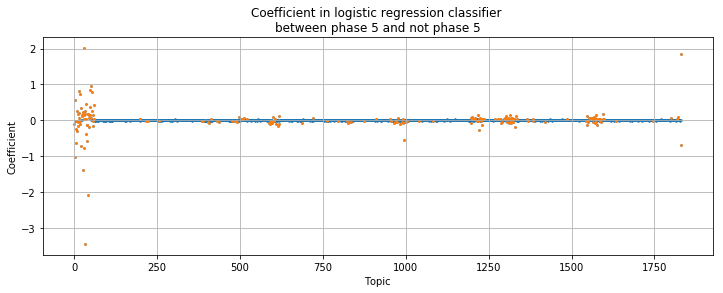

In [320]:
f = plt.figure(figsize=(12,4))
plt.scatter(range(len(clf.coef_[0])),clf.coef_[0],s=2.3)
out_std = [x for x in clf.coef_[0] if np.abs(x) > 0.025]
out_std_i = [i for i,x in enumerate(clf.coef_[0]) if np.abs(x) > 0.025]
plt.scatter(out_std_i,out_std,s=2.8)
#plt.xticks(range(0,len(clf.coef_[0])+1,2),rotation=90)
#plt.ylim(-1,1)
plt.xlabel('Topic')
plt.ylabel('Coefficient')
plt.title('Coefficient in logistic regression classifier \nbetween phase 5 and not phase 5')
plt.grid()

In [276]:
np.round(np.mean(clf.coef_[0]),4)
np.std(clf.coef_[0])

0.13948049514549332

### Important Topics

In [277]:
a_name = 'lda_textbooks_chunksize_alpha_auto_seed_{}_{}_{}_{}.pickle'.format(SEED,num_topics,REMOVE_STOPWORDS,WITH_STEMMING)
model_file = os.path.join(results_path,'lda_models',a_name)
with open(model_file,'rb') as f:
    ldamodel = pickle.load(f)

In [278]:
les_ids = np.argsort(np.abs(clf.coef_[0]))[-20:]

In [279]:
list(zip(np.argsort(np.abs(clf.coef_[0]))[-20:],clf.coef_[0][les_ids]))

[(59, 0.42291662551831805),
 (36, 0.44141660228768187),
 (996, -0.5614521266331938),
 (39, -0.5695454480533243),
 (1, 0.5766283763097153),
 (5, -0.6436061893160816),
 (1830, -0.6931347984955678),
 (20, -0.7196883669403833),
 (17, 0.7450395898245719),
 (29, -0.766709422928716),
 (55, 0.7917748681270895),
 (13, 0.81730375839288),
 (48, 0.8369595289960916),
 (50, 0.9658195197363973),
 (3, -1.0288911938194143),
 (26, -1.398642594005461),
 (1831, 1.8504564397029168),
 (30, 2.0129143186997),
 (43, -2.0941956568180364),
 (33, -3.4546430276465623)]

In [283]:
print(df.columns[996])
print(df.columns[1830+7])
print(df.columns[1831+7])

Topic 44-Topic 34
length utterance
utterance_relative_time


Topics

In [114]:
ldamodel.show_topic(33)

[('NUMBER', 0.6798587),
 ('a', 0.08793937),
 ('b', 0.07294916),
 ('c', 0.04292229),
 ('d', 0.022924542),
 ('lask', 0.007425218),
 ('+', 0.005417729),
 ('yhtälö', 0.003409941),
 ('kirj', 0.00226472),
 ('A_NAME', 0.002003389)]

In [118]:
ldamodel.show_topic(43)

[('EQUAL_SYMBOL', 0.16383563),
 ('n', 0.10167014),
 ('e', 0.08339013),
 ('NUMBER', 0.07767182),
 ('v', 0.050334003),
 ('k', 0.05002136),
 ('s', 0.045941617),
 ('m', 0.044747524),
 ('T_', 0.04445801),
 ('o', 0.035047248)]

In [131]:
ldamodel.show_topic(30)

[('a', 0.0762239),
 ('b', 0.031992134),
 ('c', 0.026608875),
 ('e', 0.023899583),
 ('oike', 0.01626492),
 ('kuva', 0.014383731),
 ('rin', 0.014164257),
 ('tulo', 0.012914545),
 ('kirj', 0.012067141),
 ('suuremp', 0.0119486265)]

### Plot phrases

In [321]:
print(len(X_train))
print(len(X_train[0]))

1509
1832


In [400]:
amat2 = np.ones((len(X_train[0]),len(X_train)))
for i in range(len(X_train[0])):
    lali = []
    for element in X_train:
        lali.append(element[i])
    amat2[i,:] =np.array(lali)
    
means = [np.mean(amat2[i]) for i in range(len(X_train[0]))]

X_train_centered = []
for i in range(len(X_train)):
    row = []
    for j in range(len(X_train[0])):
        row.append(X_train[i][j]-means[j])
    X_train_centered.append(row)

In [401]:
# make 3-class dataset for classification
pca = PCA(n_components=2)
pca.fit(X_train_centered)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [402]:
sum(pca.explained_variance_ratio_)

0.7018156396287336

In [403]:
v_1 = pca.components_[0]
v_2 = pca.components_[1]

In [404]:
np.argsort(np.abs(v_1))

array([1466, 1493, 1411, ...,   33, 1830, 1831], dtype=int64)

In [405]:
v_1[np.argsort(np.abs(v_1))]

array([ 9.08631037e-09, -1.56455725e-08,  2.38691075e-08, ...,
        1.02546693e-02,  1.88256500e-02,  9.99569528e-01])

In [406]:
v_2[np.argsort(v_2)]

array([-0.19461998, -0.03009704, -0.02817523, ...,  0.22636282,
        0.27242523,  0.90742697])

In [407]:
len(X_train)

1509

In [408]:
Xdot = np.dot(X_train_centered,pca.components_.T)

In [409]:
pca.components_.shape
Xdot.shape

(1509, 2)

In [391]:
colors = {0:'purple',1:'r',2:'b',3:'g',4:'y',5:'black'}


In [410]:
Xdot

array([[-0.49844889, -0.10026281],
       [-0.48777492,  0.00221952],
       [-0.47517967,  0.0621451 ],
       ...,
       [ 0.48277991, -0.11660206],
       [ 0.48841528, -0.04055118],
       [ 0.49683244, -0.10302328]])

(array([720., 516., 172.,  61.,  21.,   9.,   5.,   2.,   1.,   2.]),
 array([-0.14380463, -0.03424566,  0.0753133 ,  0.18487226,  0.29443123,
         0.40399019,  0.51354915,  0.62310811,  0.73266708,  0.84222604,
         0.951785  ]),
 <a list of 10 Patch objects>)

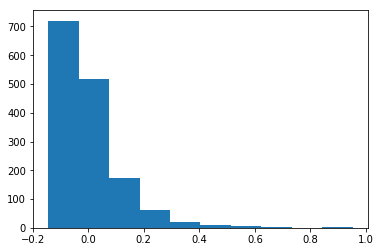

In [411]:
plt.hist([x[1] for x in Xdot])

In [431]:
X_train,y_train1 = get_data_from_dict_filter(trainset,1)
X_train,y_train2 = get_data_from_dict_filter(trainset,2)
X_train,y_train3 = get_data_from_dict_filter(trainset,3)
X_train,y_train4 = get_data_from_dict_filter(trainset,4)
X_train,y_train5 = get_data_from_dict_filter(trainset,5)

In [432]:
y_train2 = np.array(y_train1)+np.array(y_train2)+np.array(y_train3)+np.array(y_train4)+np.array(y_train5)

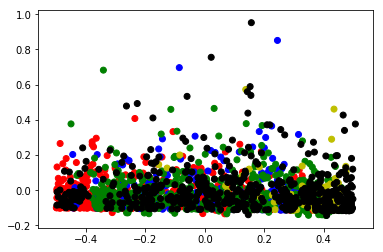

In [433]:

color_label = [colors[i] for i in y_train2]
plt.scatter([x[0] for x in Xdot],[x[1] for x in Xdot],color=color_label)
#plt.ylim(-0.2,0.5)